# Принятие решений в бизнесе на основе данных
## Оглавление
* [Загрузка данных и подготовка их к анализу](#h1_1)
* [Часть 1. Приоритизация гипотез](#h1_2)
* [Часть 2. Анализ A/B-теста](#h1_3)
* [Общий вывод](#h1_4)

## Описание проекта
В интернет-магазине проводится A/B-тестирование с целью увеличить выручку.
Необходимо:
* приоритизировать гипотезы;
* проанализировать корректность проведения и результаты A/B-теста.

Исходные данные: список и описание гипотез, файлы с результатами A/B-теста.

### Общие функции для работы с данными

In [3]:
# Импорт необходимых библиотек
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
    
# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

# Отключение предупреждений SettingWithCopyWarning
pd.options.mode.chained_assignment = None

## Загрузка данных и подготовка их к анализу <a class="anchor" id="h1_1"></a>

In [4]:
# Открытие файлов и создание датафреймов

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Данные о гипотезах
Посмотрим общую информацию и примеры данных:

In [5]:
hypothesis.info()
display(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Для удобства последующей работы переименуем названия колонок в нижний регистр:

In [6]:
hypothesis.columns= hypothesis.columns.str.lower()

### Данные о заказах

In [7]:
orders.info()
display(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Переименуем названия столбцов:

In [8]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

Приведем колонку `date` к типу даты:

In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим, есть ли в данных пользователи, попавшие в обе группы A и B:

In [10]:
intersectUsers = np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())
print(intersectUsers)

[   8300375  199603092  232979603  237748145  276558944  351125977
  393266494  457167155  471551937  477780734  818047933  963407295
 1230306981 1294878855 1316129916 1333886533 1404934699 1602967004
 1614305549 1648269707 1668030113 1738359350 1801183820 1959144690
 2038680547 2044997962 2378935119 2458001652 2579882178 2587333274
 2600415354 2654030115 2686716486 2712142231 2716752286 2780786433
 2927087541 2949041841 2954449915 3062433592 3202540741 3234906277
 3656415546 3717692402 3766097110 3803269165 3891541246 3941795274
 3951559397 3957174400 3963646447 3972127743 3984495233 4069496402
 4120364173 4186807279 4256040402 4266935830]


Удалим данных пользователей из массива заказов:

In [11]:
orders = orders[np.logical_not(orders['visitor_id'].isin(intersectUsers))]

### Данные о пользователях, совершивших заказ

In [12]:
visitors.info()
display(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


Приведем колонку `date` к типу даты:

In [13]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Выводы по шагу предобработки данных
В результате предобработки выполнено следующее:
* Данные из файлов загружены в датафреймы.
* Колонки с датами приведены к типу `date`.
* Из таблицы `orders` удалены пользователи, которые оказались в обеих группах A и B.
* Изменены названия колонок на более удобные.

## Часть 1. Приоритизация гипотез<a class="anchor" id="h1_2"></a>
В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

#### 1. Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
Формула для расчета ICE:
$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [34]:
# Расчет значений ICE
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

# Увеличение максимального значения отображаемых символов в колонке
pd.set_option("max_colwidth", 200)

# Вывод на экран
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по ICE: 8, 0, 7, 6, 2.

#### 2. Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
Формула для расчета RICE:
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [15]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['ICE']

display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По RICE список наиболее перспективных гипотез остался тем же. Но их порядок изменился. Теперь на первом месте стоит гипотеза 7. Это случилось из-за того, что параметр Reach (как много пользователей затронет гипотеза) данной гипотезы самый высокий - 10.

Гипотеза 8 оказалась уже на пятом месте. У нее параметр Reach самый низкий среди всех - 1.


$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

## Часть 2. Анализ A/B-теста<a class="anchor" id="h1_3"></a>
Вы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и /`datasets/visitors.csv`.

### Задача
Проанализируйте A/B-тест:
1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
1. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
1. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
1. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.
1. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.
1. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
1. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
1. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
1. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
1. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
1. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
1. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
1. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
1. Примите решение по результатам теста и объясните его. Варианты решений: 
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

#### 1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


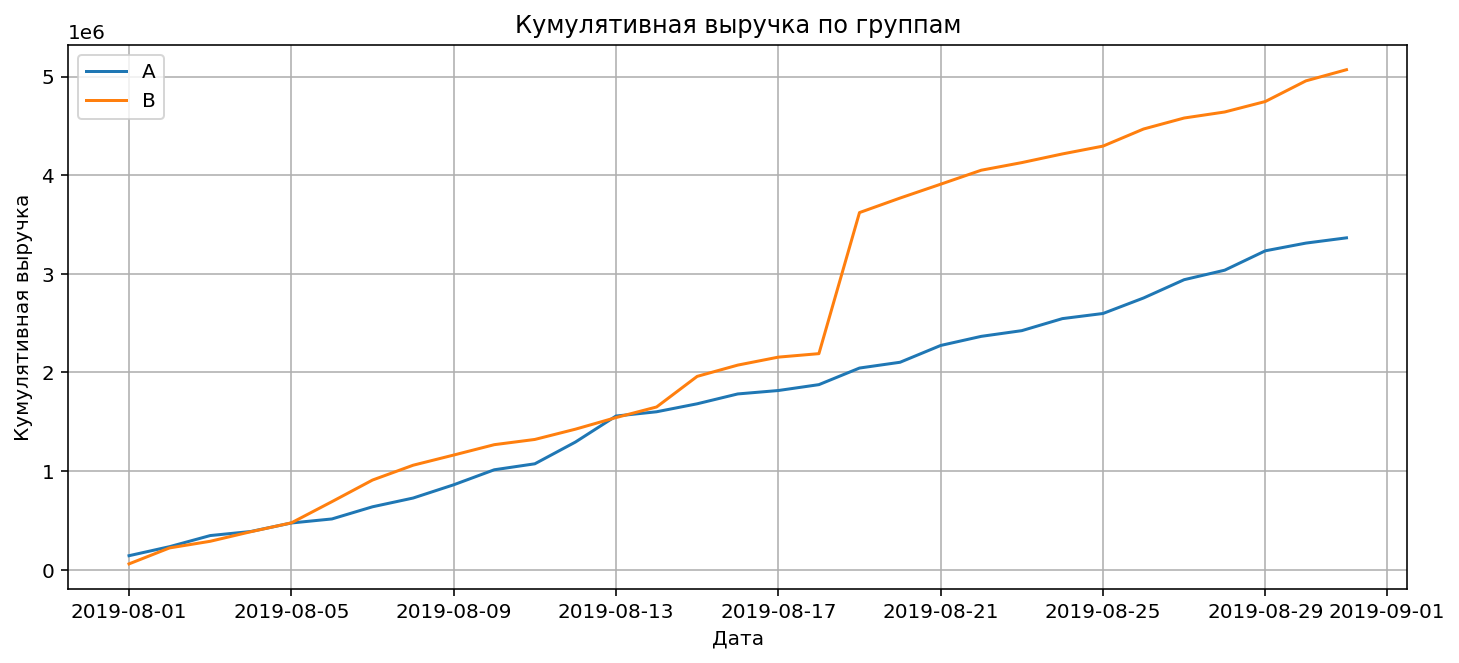

In [16]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData)

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим графики
plt.figure(figsize=(12,5))
plt.grid(True)
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
# график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.show()

Практически с самого начала теста сегмент B показывал результаты чуть выше, чем сегмент А, и продолжал лидировать весь остаток теста. Но в середине теста сегмент B резко вырвался вперед. Похоже, что аномально большие заказы всё-таки влияют на результаты. При заключительном анализе их нужно удалить.

#### 2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

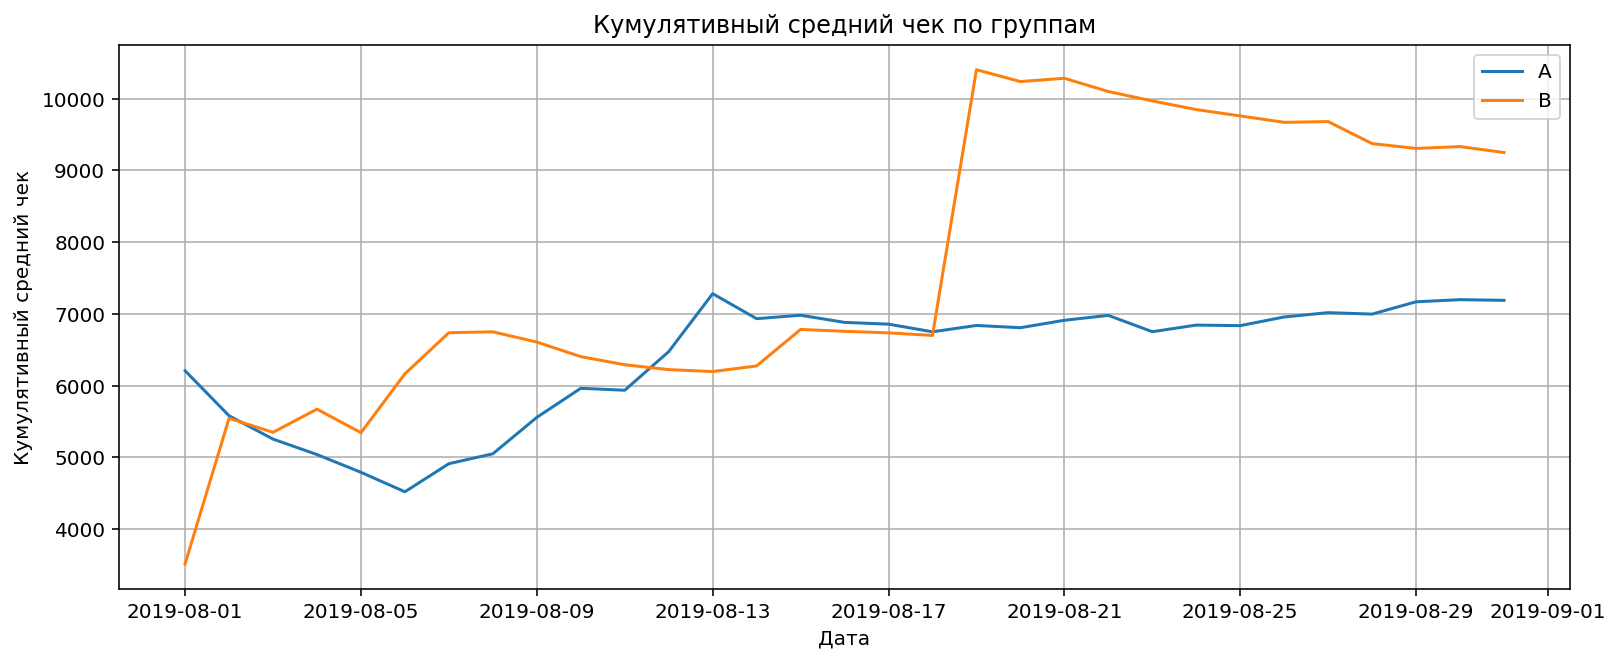

In [17]:
plt.figure(figsize=(13,5))
plt.grid(True)
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.show()

Кумулятивное значение среднего чека по сегментам продолжает колебаться. Скорее всего, принимать решение по этой метрике рано. Или требуется дополнительный анализ выбросов, которые так сильно искажают результат.

#### 3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

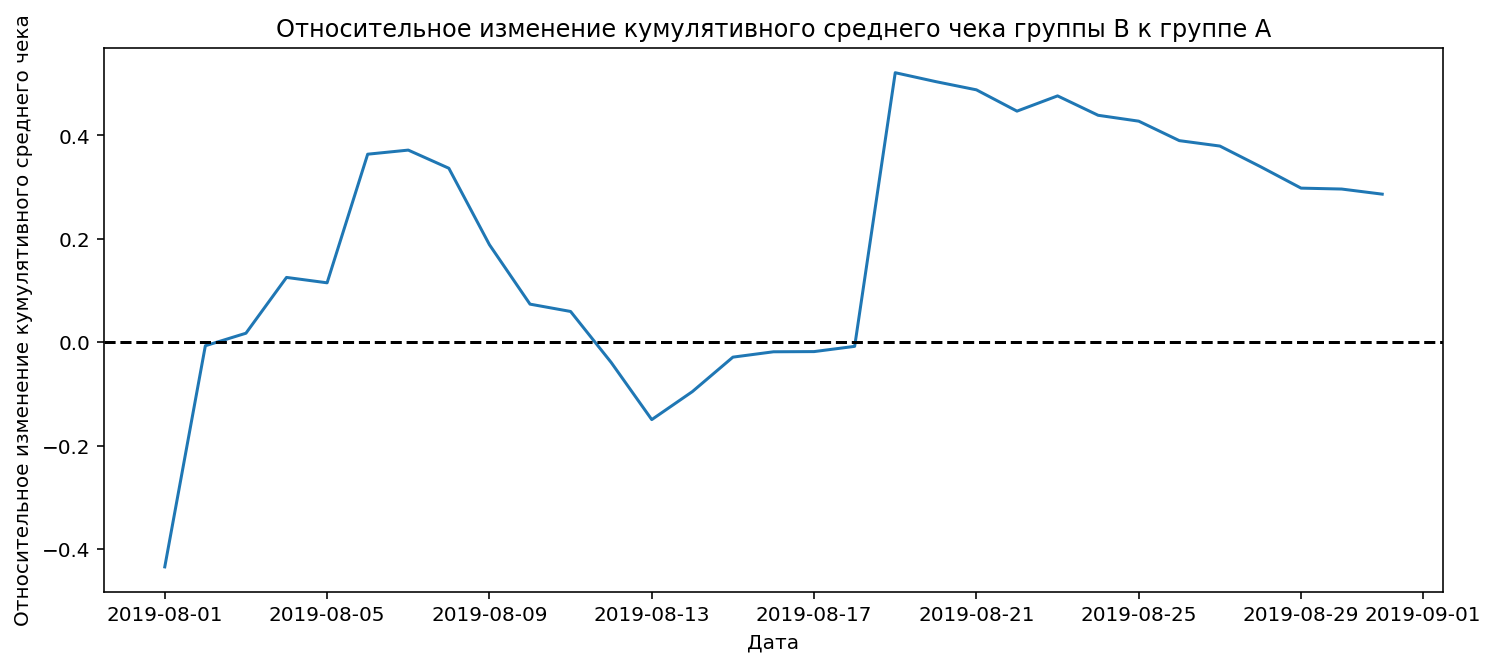

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(12,5))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего чека')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Результаты теста значительно и резко менялись в несколько дат. Возможно, что именно тогда были совершены аномальные заказы.

#### 4. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

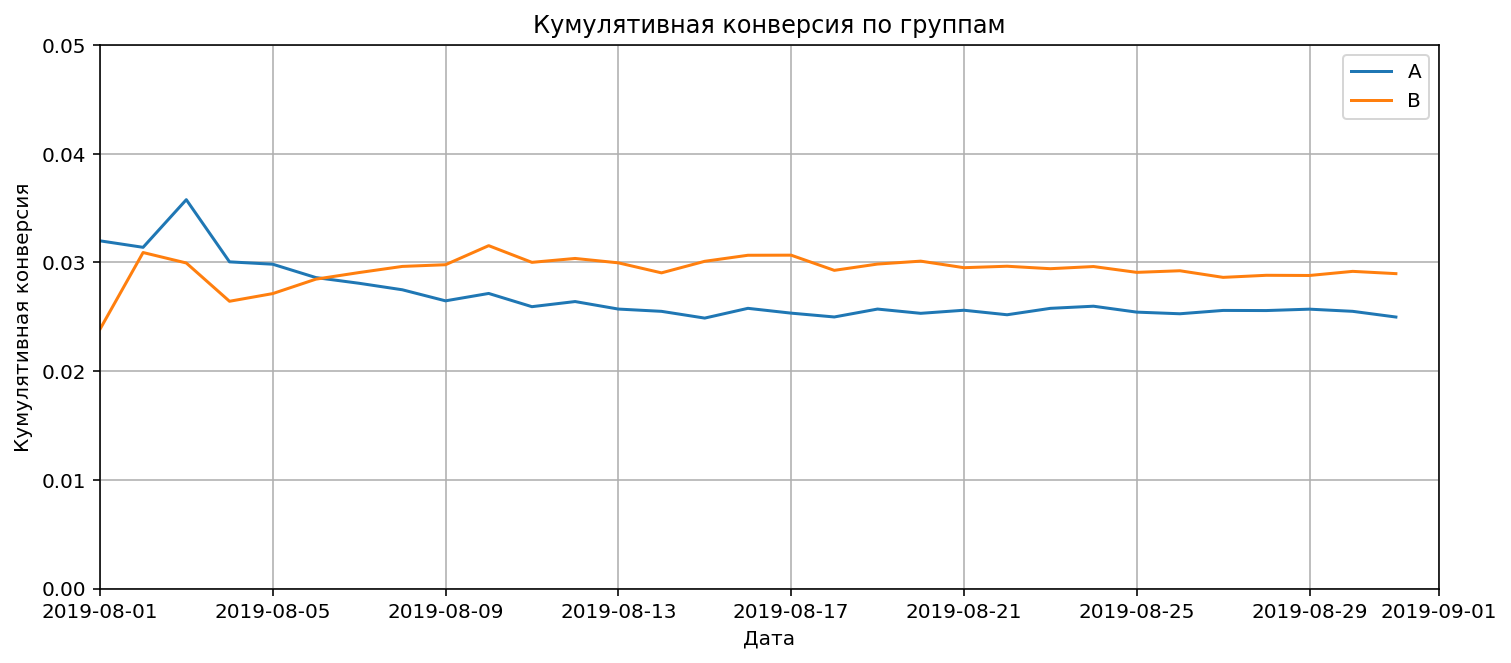

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12,5))
plt.grid(True)
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), 0, 0.05])
plt.show()

В начале теста сегмент A имел большую конверсию, но постепенно сегмент B выровнялся и зафикировался примерно около одного значения, больше значения сегмента A. Видно, что абсолютное значение колебания в начале и в конце теста не слишком большое: от 3% до 4%. В относительных величинах — это примерно на 30%. Потому, если убрать масштаб осей, будет казаться, что колебания продолжаются, и конверсия не установилась около своего среднего значени.

#### 5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

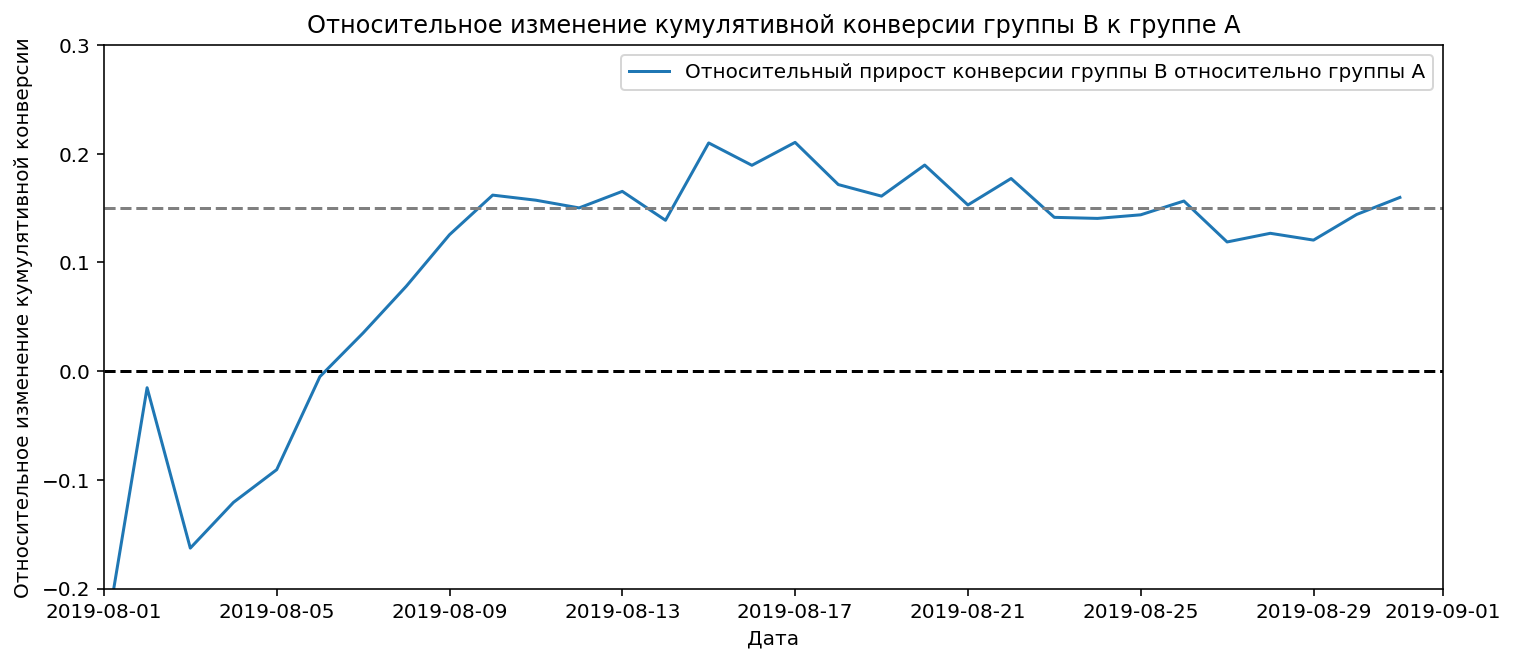

In [20]:
# объединение таблицы cumulativeDataA и cumulativeDataB
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# построение графика
plt.figure(figsize=(12,5))
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), -0.2, 0.3])
plt.show()

Почти с самого начала теста группа B лидирует по конверсии: наблюдается прирост в среднем от 10% до 20% относительно группы А.

#### 6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

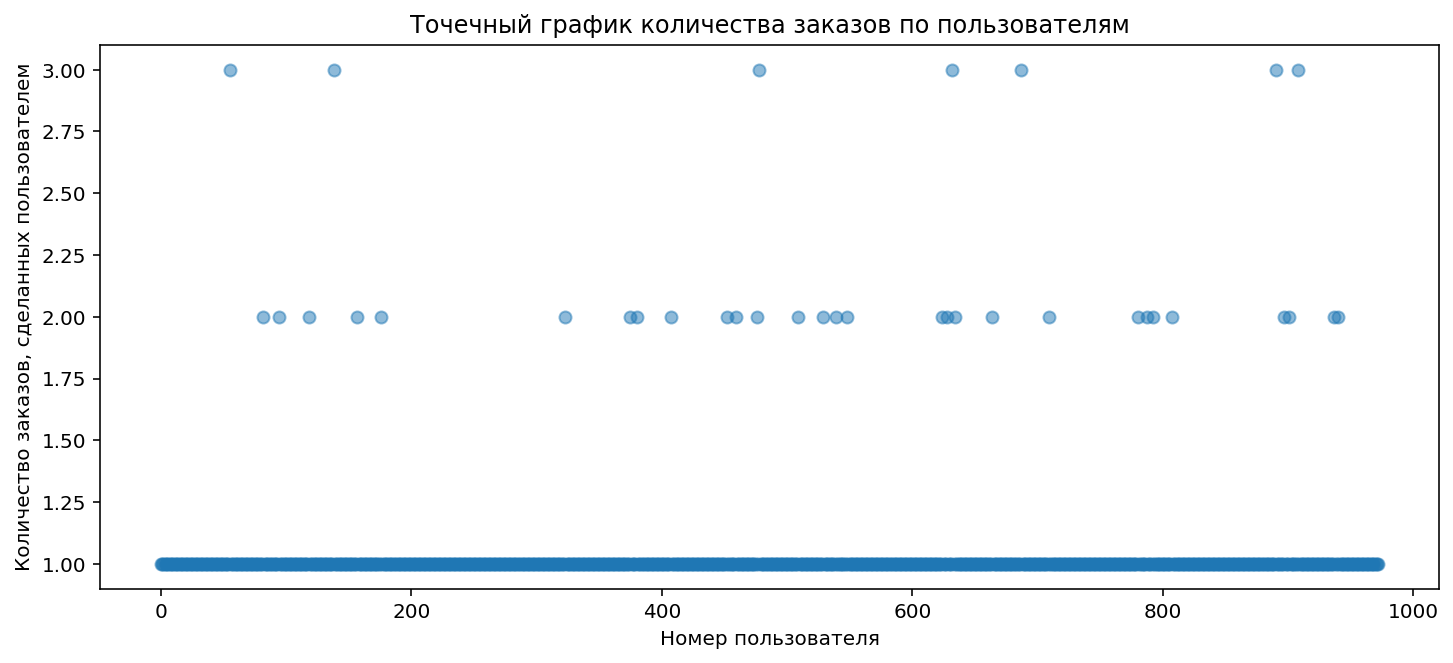

In [21]:
# создание сводной таблицы количества заказов по пользователям
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
# переименование колонок
ordersByUsers.columns = ['visitor_id','orders']

# серия из чисел от 0 до количества пользователей в ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))

# построение гистограммы распределения числа заказов по пользователям методом hist().
plt.figure(figsize=(12,5))
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов, сделанных пользователем')
plt.scatter(x_values, ordersByUsers['orders'], alpha= 0.5)
plt.show()

Пользователей, заказавших более одного раза, очень мало. Они вполне могут быть аномальными.

#### 7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [22]:
# Нахождение перцентилей методом np.percentile
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей совершали больше 2 заказов. И не более 1% пользователей — больше 4 заказов.

#### 8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

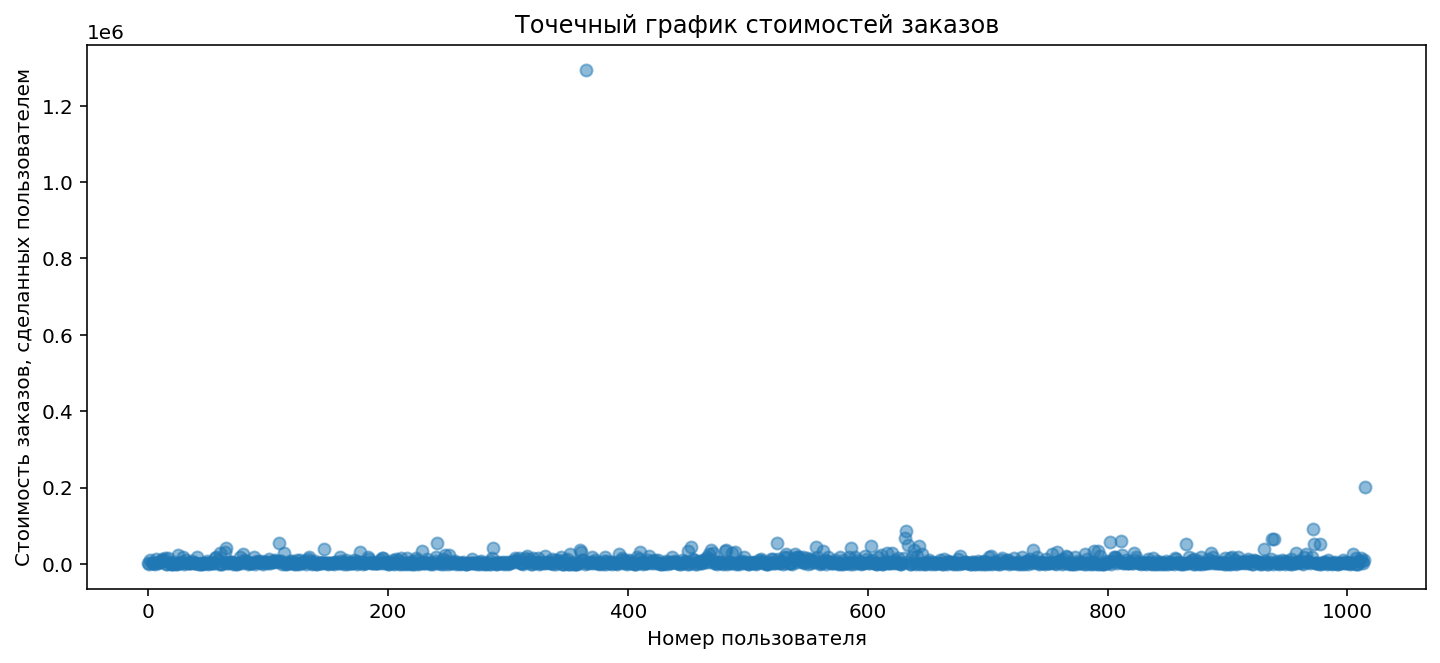

In [23]:
# серия из чисел от 0 до количества пользователей в orders
x_values = pd.Series(range(0,len(orders['revenue'])))

# построение графика
plt.figure(figsize=(12,5))
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Номер пользователя')
plt.ylabel('Стоимость заказов, сделанных пользователем')
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.show()

Заказов стоимостью 50 000 рублей очень мало. Есть выбросы в районе 50 000 - 200 000 и  1 300 000 рублей. Заказ на 1.3 миллиона выглядит аномально.

#### 9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [24]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более, чем у 5% заказов стоимость заказа дороже 28 000 рублей. И не больше, чем у 1% заказов — дороже 58 233 рублей.

#### 10. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
Сформулируем нулевую (Н0) и альтернативную гипотезы (Н1) следующим образом:

**Н0**: Конверсии групп А и B равны.

**Н1**: Конверсии групп А и B отличаются.

In [25]:
# создание сводной таблицы с количеством посетилей группы А по датам
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# создание сводной таблицы с кумулятивным количеством посетилей группы А по датам
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# создание сводной таблицы с количеством посетилей группы B по датам
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# создание сводной таблицы с кумулятивным количеством посетилей группы B по датам
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# создание сводной таблицы со статистикой по группе A
ordersADaily = orders[orders['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# создание сводной таблицы с кумулятивной статистикой по группе A
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# создание сводной таблицы со статистикой по группе B
ordersBDaily = orders[orders['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# создание сводной таблицы с кумулятивной статистикой по группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# объединение полученных таблиц в одну
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

# создание таблиц для каждой группы , где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders']

# cоздание таблиц, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули.
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('Результаты проверки различия в конверсии по «сырым» данным:')
print('p-value теста Манна-Уитни: {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))
print('Относительное различие между группами: {0:.1%}'.format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)) 

Результаты проверки различия в конверсии по «сырым» данным:
p-value теста Манна-Уитни: 0.011
Относительное различие между группами: 16.0%


p-value меньше 0.05. Таким образом, нулевую гипотезу отвергаем: анализ «сырых» данных показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A равен 16%.

#### 11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
Сформулируем нулевую (Н0) и альтернативную гипотезы (Н1) следующим образом:

**Н0**: Средние чеки заказа групп А и B равны.

**Н1**: Средние чеки заказа групп А и B отличаются.

In [26]:
print('Результаты проверки различия в среднем чеке по «сырым» данным:')
print('p-value теста Манна-Уитни: {0:.3f}'.
      format(st.mannwhitneyu(
          orders[orders['group']=='A']['revenue'],
          orders[orders['group']=='B']['revenue'],alternative='two-sided')[1]))

print('Относительное различие между группами: {0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Результаты проверки различия в среднем чеке по «сырым» данным:
p-value теста Манна-Уитни: 0.829
Относительное различие между группами: 28.7%


p-value больше 0.05: статистически значимых отличий в среднем чеке между группами нет. В то же время относительное различие среднего чека между сегментами составило 28.7%. Необходимо попробовать удалить аномалии и пересчитать тест Манна-Уитни.

#### Очистка данных (удаление аномалий)

Напомним, что 95-й и 99-й перцентили средних чеков равны 28000 и 58 233 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.

Примем за аномальных пользователей тех, кто совершил 3 заказа и более, или совершил заказ на сумму свыше 30 000 рублей. Так мы уберем д 5% пользователей с наибольшим числом заказов и с наибольшей стоимостью.

In [27]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitor_id, dtype: int64
(49,)


Теперь у нас есть множество аномальных пользователей. После их удаления можно пересчитать статистическую значимость. Надо выяснить, есть ли существенные различия между группами с очищенными данными.

#### 12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
Нулевая и альтернативная гипотезы формулируются аналогично п. 10.

In [28]:
# Созданиеие переменных с очищенными данными о заказах — не включая аномальных пользователей.
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

print('Результаты проверки различия в конверсии после очистки данных:')
print('p-value теста Манна-Уитни: {0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))
print('Относительное различие между группами: {0:.1%}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Результаты проверки различия в конверсии после очистки данных:
p-value теста Манна-Уитни: 0.00971
Относительное различие между группами: 18.7%


Как и в случае с «сырыми» данными, статистическая значимость достигнута: сегмент B значительно лучше сегмента A.

#### 13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
Нулевая и альтернативная гипотезы формулируются аналогично п. 11.

In [29]:
print('Результаты проверки различия в среднем чеке после очистки данных:')
print('p-value теста Манна-Уитни: {0:.5f}'.format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    alternative='two-sided')[1]))

print('Относительное различие между группами: {0:.1%}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

Результаты проверки различия в среднем чеке после очистки данных:
p-value теста Манна-Уитни: 0.74088
Относительное различие между группами: -2.7%


После удаления аномалий p-value немного снизилось, но все также значительно больше 0.05. При этом относительное различие между группами значительно снизилось: теперь средний чек группы B меньше на 2.7%, чем у группы А. Таким образом, статистически значимых отличий в среднем чеке между группами нет.

##  Общий вывод<a class="anchor" id="h1_3"></a>
Результаты решённых в проекте задач:
* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
* Нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и после удаления аномалий.
* Согласно графику различия конверсии между группами, результаты группы B лучше группы A: наблюдается прирост в среднем около 16% относительно группы А.
* Из графика различия среднего чека сделать определённые выводы нельзя: значения сильно колеблятся. Но он позволил нам найти аномалии.

Таким образом, можно остановить тест, признать его успешным и зафиксировать победу группы B.